# Preparation 
## Append to path and import
In case gumpy is not installed as package, you may have to specify the path to the gumpy directory

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt 

import sys, os, os.path
sys.path.append('../..')

## import gumpy
This may take a while, as gumpy as several dependencies that will be loaded automatically

In [24]:
import numpy as np
import gumpy

# Import data
To import data, you have to specify the directory in which your data is stored in. For the example given here, the data is in the subfolder ``../EEG-Data/Graz_data/data``. 
Then, one of the classes that subclass from ``dataset`` can be used to load the data. In the example, we will use the GrazB dataset, for which ``gumpy`` already includes a corresponding class. If you have different data, simply subclass from ``gumpy.dataset.Dataset``.

In [25]:
# First specify the location of the data and some 
# identifier that is exposed by the dataset (e.g. subject)
base_dir = '../..'
subject = 'S1'

# The next line first initializes the data structure. 
# Note that this does not yet load the data! In custom implementations
# of a dataset, this should be used to prepare file transfers, 
# for instance check if all files are available, etc.
data_low = gumpy.data.NST_EMG(base_dir, subject, 'low')
data_high = gumpy.data.NST_EMG(base_dir, subject, 'high') 

# Finally, load the dataset
data_low.load()
data_high.load()

The abstract class allows to print some information about the contained data. This is a commodity function that allows quick inspection of the data as long as all necessary fields are provided in the subclassed variant.

In [26]:
data_low.print_stats()
print('----------')
data_high.print_stats()

Data identification: NST_EMG-S3
EMG-data shape: (217603, 8)
Trials data shape:  (36,)
Labels shape:  (48,)
Total length of single trial:  10
Sampling frequency of EMG data: 512
Interval for motor imagery in trial:  [5, 10]
Classes possible:  [ 0.  1.  2.  3.]
----------
Data identification: NST_EMG-S3
EMG-data shape: (217610, 8)
Trials data shape:  (36,)
Labels shape:  (48,)
Total length of single trial:  10
Sampling frequency of EMG data: 512
Interval for motor imagery in trial:  [5, 10]
Classes possible:  [ 0.  1.  2.  3.]


# Signal Filtering

In [27]:
#bandpass
lowcut=20
highcut=255
#notch
f0=50
Q=50

flt_low = gumpy.signal.butter_bandpass(data_low, lowcut, highcut)
flt_low = gumpy.signal.notch(flt_low, cutoff=f0, Q=Q)

trialsLow = gumpy.utils.getTrials(data_low, flt_low)
trialsLowBg = gumpy.utils.getTrials(data_low, flt_low, True)

flt_high = gumpy.signal.butter_bandpass(data_high, lowcut, highcut)
flt_high = gumpy.signal.notch(flt_high, cutoff=f0, Q=Q)

trialsHigh = gumpy.utils.getTrials(data_high, flt_high)
trialsHighBg = gumpy.utils.getTrials(data_high, flt_high, True)


#  Data Visualization 

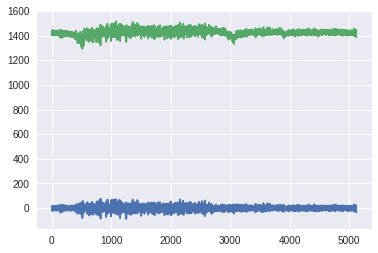

In [28]:
i=8
plt.figure()
plt.plot(flt_low[data_low.trials[i]: data_low.trials[i+1],0])
plt.plot(data_low.raw_data[data_low.trials[i]: data_low.trials[i+1],0])
plt.show()

# RMS Feature Extraction Function Creation

In [29]:
def RMS_features_extraction(data, trialList, window_size, window_shift):
    if window_shift > window_size:
        raise ValueError("window_shift > window_size")

    fs = data.sampling_freq
    
    n_features = int(data.duration/(window_size-window_shift))
    
    X = np.zeros((len(trialList), n_features*4))
    
    t = 0
    for trial in trialList:
        # x3 is the worst of all with 43.3% average performance
        x1=gumpy.signal.rms(trial[0], fs, window_size, window_shift)
        x2=gumpy.signal.rms(trial[1], fs, window_size, window_shift)
        x3=gumpy.signal.rms(trial[2], fs, window_size, window_shift)
        x4=gumpy.signal.rms(trial[3], fs, window_size, window_shift)
        x=np.concatenate((x1, x2, x3, x4))
        X[t, :] = np.array([x])
        t += 1
    return X

# Features Retrieval

In [30]:
window_size = 0.2
window_shift = 0.05

highRMSfeatures = RMS_features_extraction(data_high, trialsHigh, window_size, window_shift)
highRMSfeaturesBg = RMS_features_extraction(data_high, trialsHighBg, window_size, window_shift)
lowRMSfeatures = RMS_features_extraction(data_high, trialsLow, window_size, window_shift)
lowRMSfeaturesBg = RMS_features_extraction(data_high, trialsLowBg, window_size, window_shift)



# Constructing Classification arrays
X_tot = np.vstack((highRMSfeatures, lowRMSfeatures))
y_tot = np.hstack((np.ones((highRMSfeatures.shape[0])),
                     np.zeros((lowRMSfeatures.shape[0]))))
  
X_totSig = np.vstack((highRMSfeatures, highRMSfeaturesBg, lowRMSfeatures, lowRMSfeaturesBg))
# Normalizing the features
X_totSig = X_totSig/np.linalg.norm(X_totSig)

y_totSig = np.hstack((data_high.labels, 
                     data_low.labels))

# Classification

[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.3s finished

[2018-02-03 09:55:55] Features: 1/25 -- score: 0.53125[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2018-02-03 09:55:56] Features: 2/25 -- score: 0.5625[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2018-02-03 09:55:56] Features: 3/25 -- score: 0.5625[Parallel(n_jobs=-1)]: Done  57 out of 129 | elapsed:    0.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2018-02-03 09:55:57] Features: 4/25 -- score: 0.5625[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2018-02-03 09:55:58] Features: 5/25 -- score: 0.552083333333[

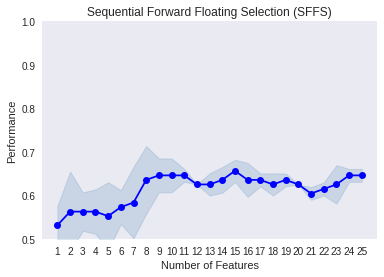

[Parallel(n_jobs=-1)]: Done 132 out of 132 | elapsed:    0.4s finished

[2018-02-03 09:56:13] Features: 1/25 -- score: 0.986111111111[Parallel(n_jobs=-1)]: Done 131 out of 131 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.0s finished

[2018-02-03 09:56:14] Features: 2/25 -- score: 0.986111111111[Parallel(n_jobs=-1)]: Done 130 out of 130 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.0s finished

[2018-02-03 09:56:15] Features: 3/25 -- score: 1.0[Parallel(n_jobs=-1)]: Done 129 out of 129 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.0s finished

[2018-02-03 09:56:16] Features: 4/25 -- score: 1.0[Parallel(n_jobs=-1)]: Done  56 out of 128 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done 128 out of 128 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:    0.0s finished

[2018-02-03 09:56:16] Features: 5/25 -- score: 1.0[Pa

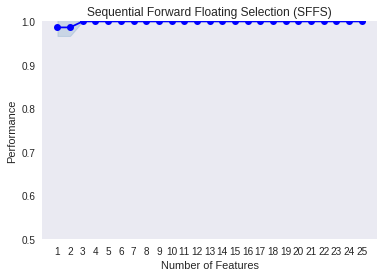

In [35]:
if __name__ == '__main__':
    # Posture Classification
    out_Classification = gumpy.features.sequential_feature_selector(X_totSig, y_totSig, 'SVM', (10,25), 3, 'SFFS')

    # Force Level Classification
    out_Force = gumpy.features.sequential_feature_selector(X_tot, y_tot, 'SVM', (10,25), 3, 'SFFS')